[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/whyhardt/SPICE/blob/main/tutorials/4_individual_differences.ipynb)

# Modeling Individual Differences in SPICE

This tutorial explains how to model and analyze individual differences in cognitive mechanisms using SPICE. You'll learn how to:
- Use participant embeddings to capture individual differences
- Train models with participant-specific parameters
- Analyze and interpret individual differences in cognitive mechanisms

## Prerequisites

Before starting this tutorial, make sure you have:
- Completed the previous tutorials
- Understanding of basic reinforcement learning concepts
- Familiarity with embedding spaces and individual differences

## Why Model Individual Differences?

By talking about individual differences, cognitive scientists are referring to individual notions in exhibited behavior, which can manifest in:
- Learning rates
- Decision noise (inverse temperature)
- Forgetting rates
- Choice perseveration
- or the model architecture itself!

SPICE can capture these differences through participant embeddings, allowing us to:
1. Model participant-specific cognitive mechanisms
2. Discover patterns in individual differences
3. Make personalized predictions

## Tutorial Contents

As a simplified case, we are going to collect data from two participants with two individual learning rates. Then, we try to recover them once with the last RNN (learning rate with hardcoded equations for the reward prediction error, precoded) and a version which implements a participant-embedding layer. As usual, we first use the precoded model and then show how to implement it.

### Individual Differences in Model Architecture
When using SPICE, we can go beyond individual differences in parameterizations of a specific model. We can also consider different model architectures for each participant!

Think of the following scenario: 

One participant exhibits only goal-directed behavior (i.e. making choices based only on the reward-based values) while another participant shows an additional positivity bias (i.e. increasing the learning rate for positive outcomes while the value is low and a decreasing the learning rate for negative outcomes while the value is high). Such a positivity bias can help to account for reward volatility, by preventing to drastic value updates in the case of an unexpected penalty ($reward = 0$). Additionally, it can also induce goal-directed exploration by making more drastic updates in the case of an unexpected reward.  -->

But that's enough theory for now. Let's get our hands dirty again!

## 1. Data generation

First of all we have to generate a dataset with multiple participants. Let's start with two different ones.

We are going generate half the dataset with participant #1 and the other half with participant #2.

In [1]:
# Uncomment the code below and execute the cellif you are using Google Colab

#!pip uninstall -y numpy pandas
#!pip install numpy==1.26.4 pandas==2.2.2

In [2]:
# Uncomment the code below and execute the cell if you are using Google Colab

#!pip install autospice

In [3]:
import numpy as np
import torch

np.random.seed(42)
torch.manual_seed(42)

In [4]:
from spice.resources.bandits import BanditsDrift, AgentQ, create_dataset
from spice.resources.rnn_utils import DatasetRNN

# Set up the environment
n_actions = 2
sigma = 0.2

environment = BanditsDrift(sigma=sigma, n_actions=n_actions)

# Set up the agents
# participant #1
agent_1 = AgentQ(
    n_actions=n_actions,
    alpha_reward=0.5,  # Symmetric learning for positive and negative outcomes in participant #1 
    forget_rate=0.2, # Forgetting mechanism in participant #1
)

# participant #2
agent_2 = AgentQ(
    n_actions=n_actions,
    alpha_reward=0.8,  # Higher learning rate for positive outcomes in participant #2
    alpha_penalty=0.2,  # Lower learning rate for negative outcomes in participant #2
    forget_rate=0.2, # Same forgetting mechanism as in participant #1 -> Shared structure
)

# Create the dataset
n_trials_per_participant = 100
n_sessions_per_participant = 50

dataset_1, _, _ = create_dataset(
    agent=agent_1,
    environment=environment,
    n_trials=n_trials_per_participant,
    n_sessions=n_sessions_per_participant,  # Generate half the dataset with participant #1
)

# change the participant id of all sessions to 0
dataset_1.xs[..., -1] = 0

dataset_2, _, _ = create_dataset(
    agent=agent_2,
    environment=environment,
    n_trials=n_trials_per_participant,
    n_sessions=n_sessions_per_participant,  # Generate the other half with participant #2
)
# Set the participant id in the second dataset to 1 in order to mark the different participants
dataset_2.xs[..., -1] = 1

# Combine the two datasets
dataset_xs = torch.cat((dataset_1.xs, dataset_2.xs))
dataset_ys = torch.cat((dataset_1.ys, dataset_2.ys))
dataset = DatasetRNN(dataset_xs, dataset_ys)
n_participants = len(dataset.xs[..., -1].unique())

print(f'Shape of the new dataset: {dataset.xs.shape}')
print(f'Number of participants: {n_participants}')

/home/daniel/miniconda3/envs/spice/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Creating dataset...


100%|██████████| 50/50 [00:00<00:00, 221.88it/s]


Creating dataset...


100%|██████████| 50/50 [00:00<00:00, 207.88it/s]

Shape of the new dataset: torch.Size([100, 100, 5])
Number of participants: 2


Let's see how different these two participants behave.

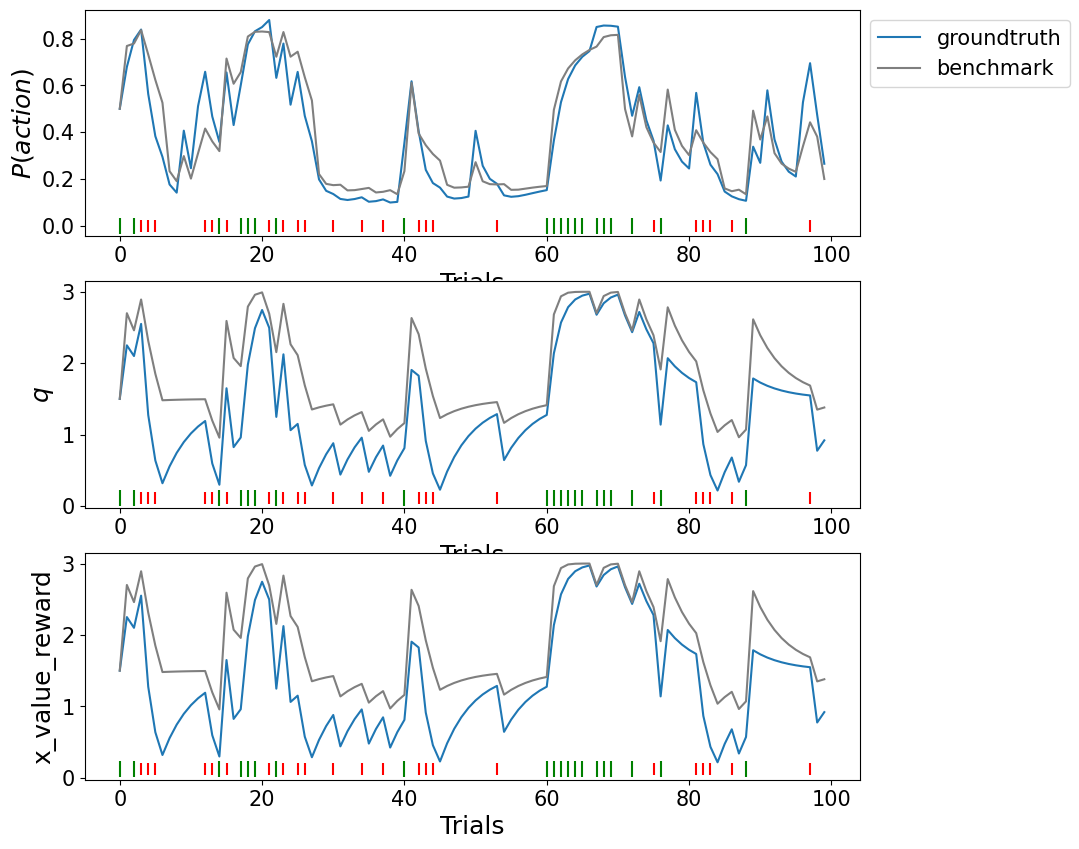

In [5]:
from spice.utils.plotting import plot_session
import matplotlib.pyplot as plt

agents = {'groundtruth': agent_1, 'benchmark': agent_2}
fig, axs = plot_session(agents, dataset.xs[0], signals_to_plot=['x_value_reward'])

plt.show()

## 2. Using the previous model without participant information

Let's inspect first how our last RNN (precoded `LearningRateRNN`) would perform in such a situation to verify the need for tackling individual differences with a participant-embedding layer.

In [14]:
from spice.estimator import SpiceEstimator
from spice.precoded import ForgettingRNN, FORGETTING_RNN_CONFIG

spice_estimator = SpiceEstimator(
    rnn_class=ForgettingRNN,
    spice_config=FORGETTING_RNN_CONFIG,
    learning_rate=1e-2,
    epochs=1024,
)

spice_estimator.fit(dataset.xs, dataset.ys)

for participant in range(2):
    print(f"\nDiscovered SPICE model for participant {participant}:")
    spice_estimator.print_spice_model(participant_id=participant)


Training the RNN...
Epoch 1024/1024 --- L(Train): 0.5746073; Time: 0.06s; Convergence: 4.84e-07
Maximum number of training epochs reached.


100%|██████████| 2/2 [00:00<00:00,  2.52it/s]


Discovered SPICE model for participant 0:
SPICE modules:
(x_value_reward_chosen)[k+1] = -1.185 1 + 0.471 x_value_reward_chosen[k] + 1.272 c_reward[k]
(x_value_reward_not_chosen)[k+1] = -0.244 1 + 0.828 x_value_reward_not_chosen[k]

Discovered SPICE model for participant 1:
SPICE modules:
(x_value_reward_chosen)[k+1] = -1.176 1 + 0.480 x_value_reward_chosen[k] + 1.287 c_reward[k]
(x_value_reward_not_chosen)[k+1] = -0.246 1 + 0.827 x_value_reward_not_chosen[k]


Let's inspect the predictions for participant #1.

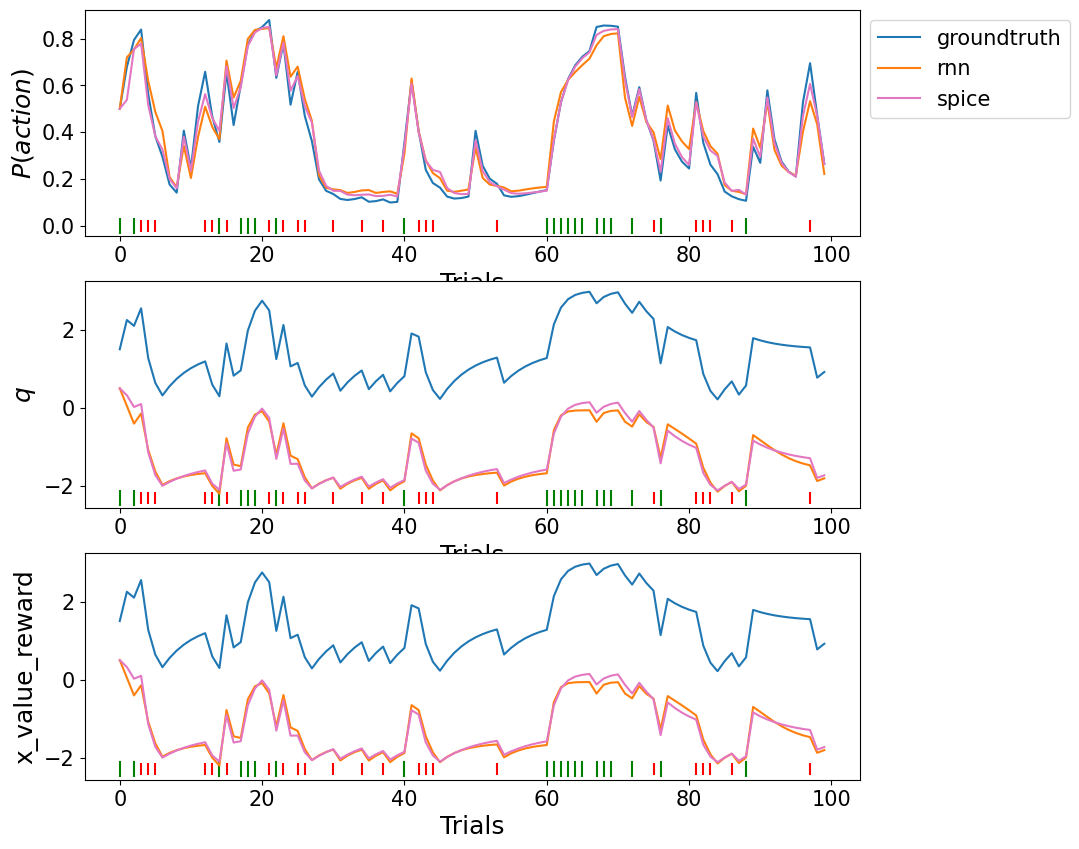

In [15]:
# get analysis plot
agents = {'groundtruth': agent_1, 'rnn': spice_estimator.rnn_agent, 'spice': spice_estimator.spice_agent}
fig, axs = plot_session(agents, dataset_1.xs[0], signals_to_plot=['x_value_reward'])
plt.show()

And now for participant #2.

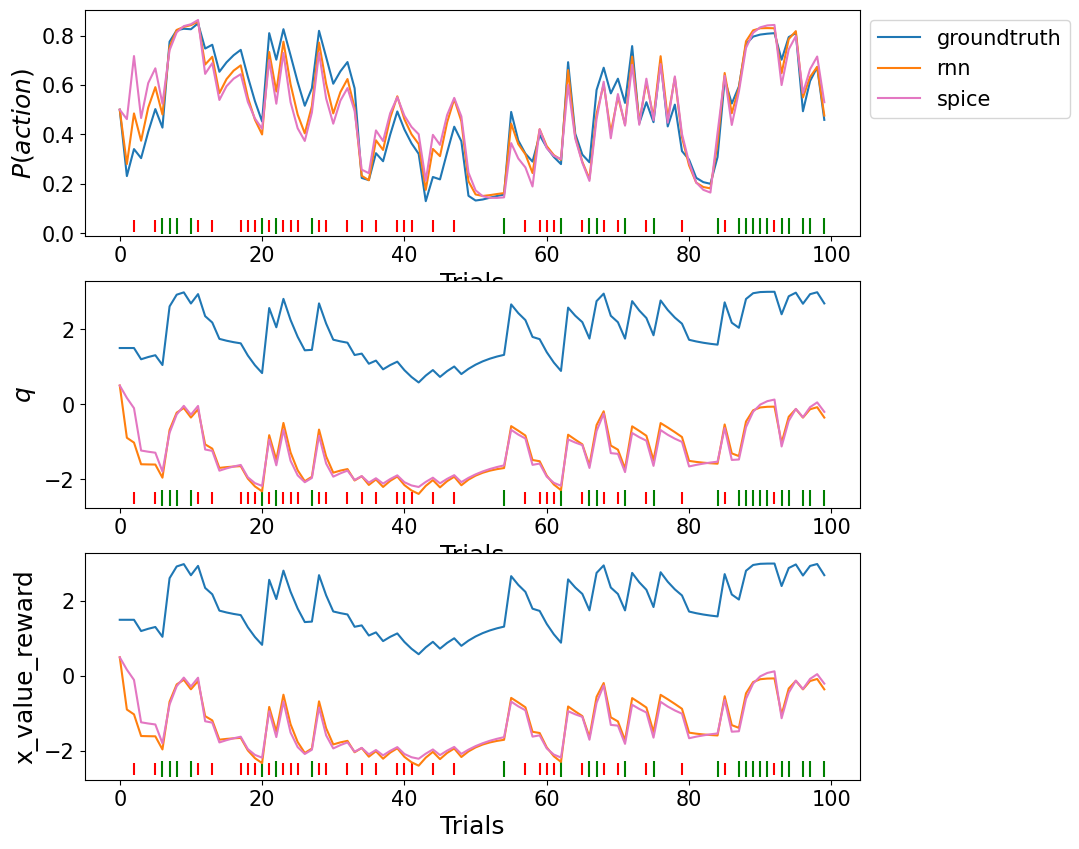

In [16]:
agents = {'groundtruth': agent_2, 'rnn': spice_estimator.rnn_agent, 'spice': spice_estimator.spice_agent}
fig, axs = plot_session(agents, dataset_2.xs[0], signals_to_plot=['x_value_reward'])
plt.show()

The fit across both participants is  worse compared to the other use-cases, where we had only one participant to fit. 

Therefore, we can definitely see the need for modeling individual differences - already in this case. The need is even stronger for real datasets with dozens of participants.  

Let's implement now a RNN which can be trained on the whole dataset but account for the differences in the individuals' behavior.

For that we are going to add a participant-embedding layer. It works similar to e.g. word-embeddings which translate a one-hot encoded vector into a dense representation in a multidimensional space.

The one-hot encoded vector corresponds to e.g. a dictionary marking the index of a certain word. After translating this word into the multidimensional space, researchers can do inference on word similarity or try to interpret the representation and extract characteristics from it.

We are making use of the embedding layer by passing a unique participant id into it and retrieve a dense representation of this participant. Afterwards we can feed this representation to the RNN-modules or compute individual noise temperatures.

That way the RNN-modules can learn *(theoretically)* any type of cognitive mechanism present in the data across all participants and the participant-embedding can give the individual notions to them by e.g. switching mechanisms on and off and parameterizing them.

## 3. Incorporating Participant Embeddings

Now we will use the precoded model with support for participant embeddings, before implementing it ourselves.

As you can imagine the individual differences can be quite subtle. Unlike big architectural differences, individual differences have to be fitted very cautiously, i.e. in the machine learning context with a very low learning rate.

Low learning rates have a couple of disadvantages, i.e. (1) they take very long to converge, and (2) they can get stuck easily in local minima. 

These are the reasons why we should use a learning rate scheduler in this scenario. The implemented learning rate scheduler can be activated in the fitting method by setting `scheduler=True`. This way we are making use of a learning rate scheduler which adjusts the learning rate dynamically.

In [ ]:
from spice.estimator import SpiceEstimator
from spice.precoded import ParticipantEmbeddingRNN, PARTICIPANT_EMBEDDING_RNN_CONFIG

# Get the number of participants from data
participant_ids = dataset.xs[..., -1].unique()
n_participants = len(participant_ids)

spice_estimator_participant_embedding = SpiceEstimator(
    rnn_class=ParticipantEmbeddingRNN,
    spice_config=PARTICIPANT_EMBEDDING_RNN_CONFIG,  # Same config as before
    learning_rate=1e-2,
    epochs=2048,
    scheduler=False,
    l2_weight_decay=0.0001,
    n_participants=n_participants,
)

spice_estimator_participant_embedding.fit(dataset.xs, dataset.ys)

for participant in range(2):
    print(f"\nDiscovered SPICE model for participant {participant}:")
    spice_estimator_participant_embedding.print_spice_model(participant_id=participant)


Training the RNN...


 50%|█████     | 1/2 [00:00<00:00,  1.08it/s]/home/daniel/miniconda3/envs/spice/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
100%|██████████| 2/2 [00:01<00:00,  1.14it/s]


Discovered SPICE model for participant 0:
SPICE modules:
(x_value_reward_chosen)[k+1] = 0.094 1 + 0.464 x_value_reward_chosen[k] + 0.351 c_reward[k]
(x_value_reward_not_chosen)[k+1] = 0.097 1 + 0.805 x_value_reward_not_chosen[k]
beta(x_value_reward) = 4.1957

Discovered SPICE model for participant 1:
SPICE modules:
(x_value_reward_chosen)[k+1] = 0.209 1 + 0.523 x_value_reward_chosen[k] + 0.259 c_reward[k]
(x_value_reward_not_chosen)[k+1] = 0.077 1 + 0.853 x_value_reward_not_chosen[k]
beta(x_value_reward) = 4.2449


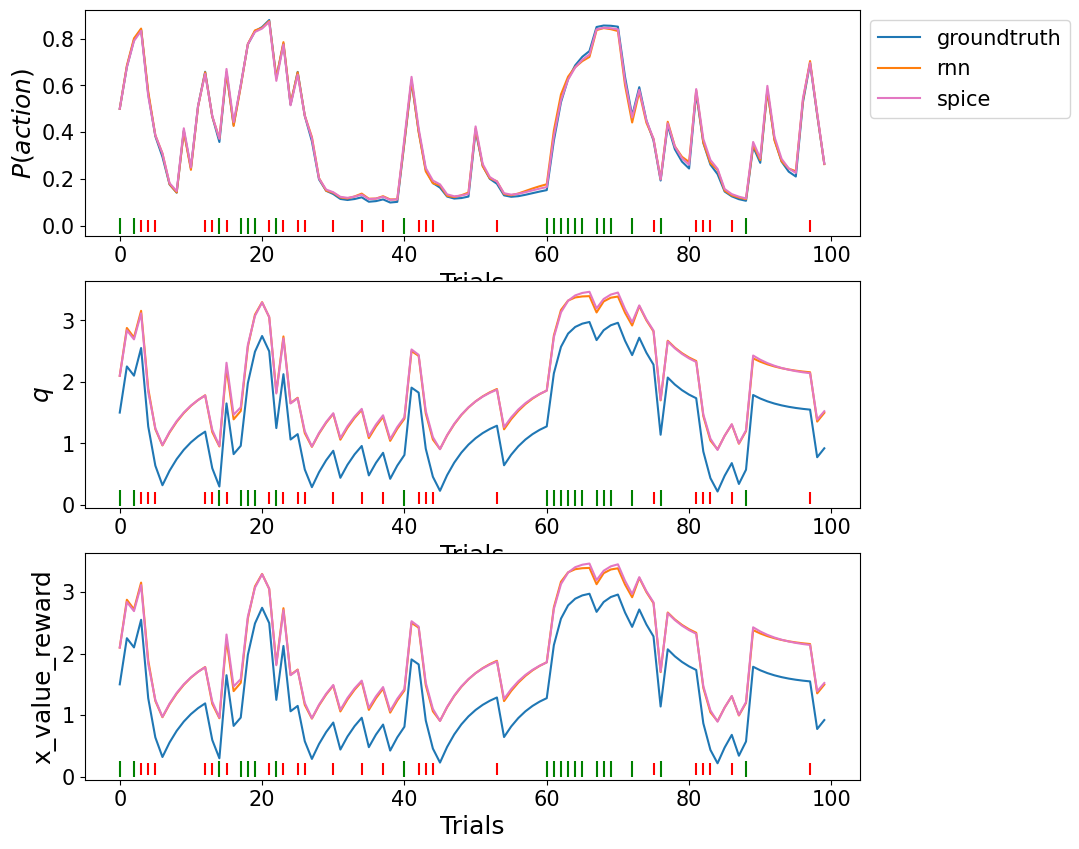

In [27]:
from spice.utils.plotting import plot_session

# get analysis plot
agents = {'groundtruth': agent_1, 'rnn': spice_estimator_participant_embedding.rnn_agent, 'spice': spice_estimator_participant_embedding.spice_agent}
fig, axs = plot_session(agents, dataset_1.xs[0], signals_to_plot=['x_value_reward'])
plt.show()

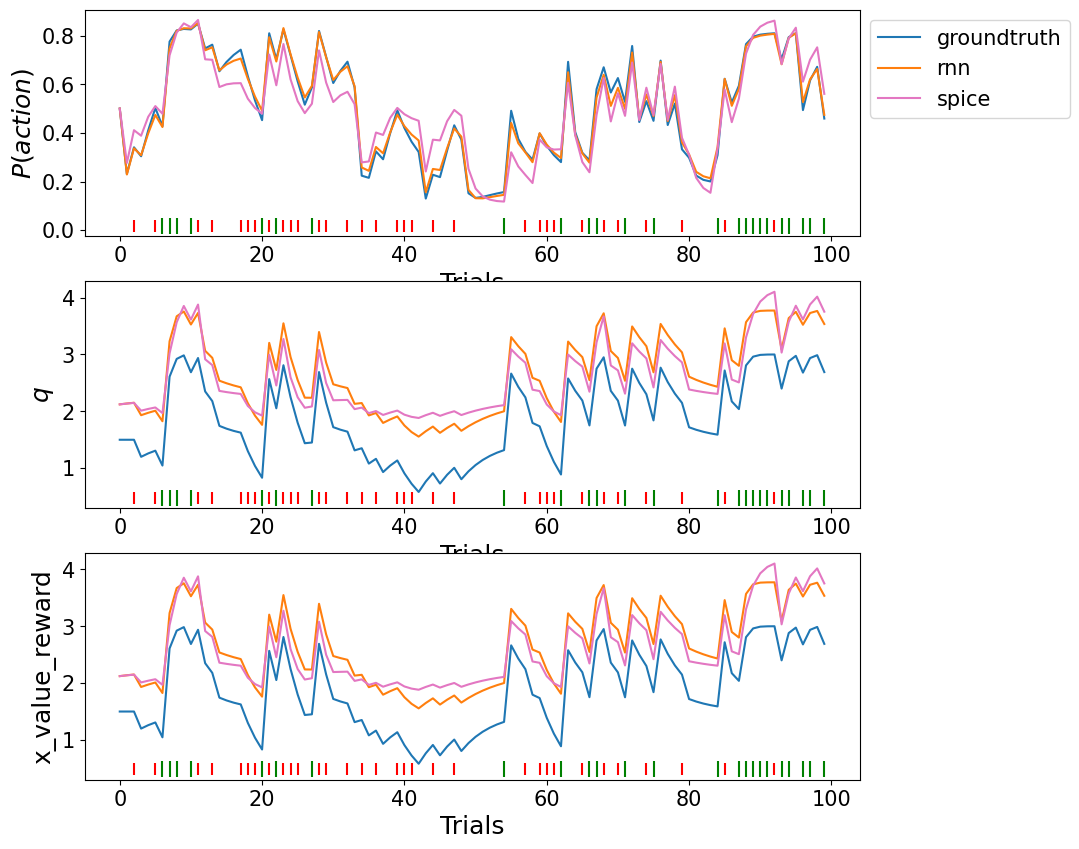

In [28]:
from spice.utils.plotting import plot_session

# get analysis plot
agents = {'groundtruth': agent_2, 'rnn': spice_estimator_participant_embedding.rnn_agent, 'spice': spice_estimator_participant_embedding.spice_agent}
fig, axs = plot_session(agents, dataset_2.xs[0], signals_to_plot=['x_value_reward'])
plt.show()

As you can see in the discovered SPICE models for each participant, we were not only able to recover the difference in learning rates but also the structural difference in terms of the forgetting mechanism.

This ability makes SPICE exceptionally powerful because we can now discover individual differences not only in terms of parameters but also in terms of model architecture. 

## 4. Implementing the RNN as a custom module

Now, we are going to implement the RNN with participant embeddings. This will be the same as the learning rate RNN implemented in the previous tutorial, with an additional embedding layer for participant IDs.

The structure of this RNN is shown in the following figure:

![](../figures/spice_rnn_participant_embedding.png)

As you can see we are going to add one module which won't be an RNN-module but instead a hard-coded equation. The learning rate on the other hand will be updated via an additional RNN-module. 

In [12]:
from spice.resources.rnn import BaseRNN
from spice.estimator import SpiceConfig


# Same config as before
CUSTOM_RNN_CONFIG = SpiceConfig(
    rnn_modules=['x_value_reward_chosen', 'x_value_reward_not_chosen'],
    
    control_parameters=['c_action', 'c_reward'],

    library_setup={
        'x_value_reward_chosen': ['c_reward'],
        'x_value_reward_not_chosen': [],
    },

    filter_setup={
        'x_value_reward_chosen': ['c_action', 1, True],
        'x_value_reward_not_chosen': ['c_action', 0, True],
    },
)

class CustomRNN(BaseRNN):
    
    init_values = {
            'x_value_reward': 0.5,
        }
    
    def __init__(
        self,
        n_actions,
        # add an additional inputs to set the number of participants in your data
        n_participants,
        **kwargs,
    ):
        
        # Add here the embedding size as an additional argument
        super(CustomRNN, self).__init__(n_actions=n_actions, embedding_size=4)
        
        # Additional embedding layer for participant information
        # NOTE: In realistic setups embedding_size=32 and additional dropout=0.5 (can be passed as an kwarg to setup_embedding) have proven to be useful
        self.participant_embedding = self.setup_embedding(num_embeddings=n_participants, embedding_size=self.embedding_size, dropout=0.)
        
        # Add a scaling factor (inverse noise temperature) for each participant.
        self.betas['x_value_reward'] = self.setup_constant(embedding_size=self.embedding_size)
        
        # and here we specify the general architecture
        # add to the input_size the embedding_size as well because we are going to pass the participant-embedding to the RNN-modules
        # set up the submodules
        self.submodules_rnn['x_value_reward_chosen'] = self.setup_module(input_size=1+self.embedding_size)
        self.submodules_rnn['x_value_reward_not_chosen'] = self.setup_module(input_size=0+self.embedding_size)
        
    def forward(self, inputs, prev_state=None, batch_first=False):
        """Forward pass of the RNN

        Args:
            inputs (torch.Tensor): includes all necessary inputs (action, reward, participant id) to the RNN to let it compute the next action
            prev_state (Tuple[torch.Tensor], optional): That's the previous memory state of the RNN containing the reward-based value. Defaults to None.
            batch_first (bool, optional): Indicates whether the first dimension of inputs is batch (True) or timesteps (False). Defaults to False.
        """
        
        # First, we have to initialize all the inputs and outputs (i.e. logits)
        inputs, ids, logits, timesteps = self.init_forward_pass(inputs, prev_state, batch_first)
        actions, rewards, _, _ = inputs
        participant_id, _ = ids

        # Here we compute now the participant embeddings for each entry in the batch
        participant_embedding = self.participant_embedding(participant_id[:, 0].int())
        
        for timestep, action, reward in zip(timesteps, actions, rewards):
            
            # record the inputs for training SINDy later on
            self.record_signal('c_action', action)
            self.record_signal('c_reward', reward)
            self.record_signal('x_value_reward_chosen', self.state['x_value_reward'])
            self.record_signal('x_value_reward_not_chosen', self.state['x_value_reward'])
            
            next_value_reward_chosen = self.call_module(
                key_module='x_value_reward_chosen',
                key_state='x_value_reward',
                action=action,
                inputs=(reward),
                # add participant-embedding (for RNN-modules) and participant-index (later for SINDy-modules) 
                participant_embedding=participant_embedding,
                participant_index=participant_id,
                activation_rnn=torch.nn.functional.sigmoid,
            )
            
            # Update of the not-chosen reward-based value
            next_value_reward_not_chosen = self.call_module(
                key_module='x_value_reward_not_chosen',
                key_state='x_value_reward',
                action=1-action,
                inputs=None,
                # add participant-embedding (for RNN-modules) and participant-index (later for SINDy-modules) 
                participant_embedding=participant_embedding,
                participant_index=participant_id,
                )
            
            self.state['x_value_reward'] = next_value_reward_chosen + next_value_reward_not_chosen
            
            # Now keep track of the logit in the output array
            logits[timestep] = self.state['x_value_reward'] * self.betas['x_value_reward'](participant_embedding)
        
        # post-process the forward pass; give here as inputs the logits, batch_first and all values from the memory state
        logits = self.post_forward_pass(logits, batch_first)
        
        return logits, self.get_state()

For training the custom RNN, we can use the same `SpiceEstimator` as before. We just need to pass the custom RNN class and the custom configuration. Execute the cell below to fit the custom RNN on the dataset we created earlier.

In [13]:
from spice.estimator import SpiceEstimator

spice_estimator_custom = SpiceEstimator(
    rnn_class=CustomRNN,
    spice_config=CUSTOM_RNN_CONFIG,
    learning_rate=1e-2,
    epochs=1024,
    n_participants=n_participants,
)

spice_estimator_custom.fit(dataset.xs, dataset.ys)

for participant in range(2):
    print(f"\nDiscovered SPICE model for participant {participant}:")
    spice_estimator_custom.print_spice_model(participant_id=participant)


Training the RNN...
Epoch 1024/1024 --- L(Train): 0.5852500; Time: 0.09s; Convergence: 1.51e-05
Maximum number of training epochs reached.


100%|██████████| 2/2 [00:01<00:00,  1.43it/s]


Discovered SPICE model for participant 0:
SPICE modules:
(x_value_reward_chosen)[k+1] = 0.673 1 + 0.220 x_value_reward_chosen[k] + -0.666 c_reward[k]
(x_value_reward_not_chosen)[k+1] = 1.000 x_value_reward_not_chosen[k]
beta(x_value_reward) = -1.6606

Discovered SPICE model for participant 1:
SPICE modules:
(x_value_reward_chosen)[k+1] = 0.689 1 + 0.193 x_value_reward_chosen[k] + -0.689 c_reward[k]
(x_value_reward_not_chosen)[k+1] = 1.000 x_value_reward_not_chosen[k]
beta(x_value_reward) = -1.5379


# Handling empirical data

When it comes to handling empirical data from experiments, observed behavior becomes much more complex and noisier at the same time, we are oftentimes handling only one session per participant, and the individual differences can be much stronger. All these circumstances make model fitting very difficult. 

In this context four measures proved to be very helpful:

1. Regularization via dropout: You can add the kwarg `dropout=0.5` to `setup_embedding` to increase generalizability
2. Regulization via l2-weight-decay: We trained here per default with `l2_weight_decay=1e-4`. We could increase this parameter in order to penalize the RNN for overfitting on noisy or too complex behavior. That way we are making sure that the fitted cognitive dynamics are recoverable by the default polynomial library.
3. Use a learning rate scheduler: You can activate a cyclic learning rate scheduler with warm restarts by passing the kwarg `scheduler=True` to `SpiceEstimaror`. LR scheduler proved to be helpful when it comes to fitting very subtle individual differences by decreasing the learning rate gradually. In order to not get stuck in local minima, the warm restarts are increasing the lr back to its default value.
4. When using a learning rate scheduler you have to make sure to increase the number of epochs. Until now we trained all models with 2^10=1024 epochs. For real data it basically cannot get enough. But 2^13=8192 epochs proved to be sufficient to get good results.

Keep all these steps in mind when handling empirical data and you are good to go and apply SPICE to your very own project!